## torch.nnモジュール

### nn.Linear

In [54]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [55]:
linear = nn.Linear(64, 30)

In [56]:
print(linear.weight.shape)
print(linear.bias.shape)

torch.Size([30, 64])
torch.Size([30])


### MLP実装

In [57]:
# 1. nn.クラスとF.関数を組み合わせたケース
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_output):
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)

    def forward(self, x):
        z1 = self.l1(x)
        a1 = F.relu(z1)
        x = self.l2(a1)
        return x

In [58]:
model = MLP(64, 30, 10)
X = torch.randn(5, 64)
Z = model(X)
Z.shape

torch.Size([5, 10])

In [59]:
# 2. nn.クラスのみで構成するケース
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_output):
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.relu = nn.ReLU()

    def forward(self, x):
        z1 = self.l1(x)
        a1 = self.relu(z1)
        x = self.l2(a1)
        return x

In [60]:
model = MLP(64, 30, 10)
X = torch.randn(5, 64)
Z = model(X)
Z.shape

torch.Size([5, 10])

In [61]:
# 3. Sequentialを使うケース
num_in = 64
num_hidden = 30
num_output = 10

model = nn.Sequential(
    nn.Linear(num_in, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_output)
)

In [62]:
X = torch.randn(5, 64)
Z = model(X)
Z.shape

torch.Size([5, 10])

### MLP学習

In [74]:
# 1. nn.クラスとF.関数を組み合わせたケース
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_output):
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)

    def forward(self, x):
        z1 = self.l1(x)
        a1 = F.relu(z1)
        x = self.l2(a1)
        return x

# 1. データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

# 学習データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# 2. 前処理
# 2-1. ラベルのonehotencoding
y_train = torch.tensor(y_train)
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)
y_val = torch.tensor(y_val)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2. 画像の標準化
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_train.mean()) / X_train.std()

batch_size = 30
num_batches = np.ceil(len(y_train) / batch_size).astype(int)
learning_rate = 0.01
epochs = 100

# モデルの定義
model = MLP(64, 30, 10)

# ログ
train_losses = []
val_losses = []
val_accuracies = []

# 5. for文で学習ループ作成
for epoch in range(epochs):

    shuffled_indcies = np.random.permutation(len(y_train))   # データのindexをシャッフル
    running_loss = 0.0

    for i in range(num_batches):

        # mini-batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indcies[start:end]

        # 6. 入力データxおよび教師ラベルのYを作成
        y = y_train[batch_indices]
        X = X_train[batch_indices]


        # 順伝播と逆伝播の計算
        preds = model(X)
        loss = F.cross_entropy(preds, y)
        loss.backward()
        running_loss += loss.item()

        # パラメータ更新
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        model.zero_grad()

    # validation
    with torch.no_grad():
        preds_val = model(X_val)
        val_loss = F.cross_entropy(preds_val, y_val)
        val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    
    # 損失ログ出力
    print(f'epoch: {epoch+1}: train_loss:{running_loss/num_batches}, val_loss:{val_loss.item()}, val_acuraccy:{val_accuracy.item()}')

epoch: 1: train_loss:2.29566324253877, val_loss:2.8574531078338623, val_acuraccy:0.24444444477558136
epoch: 2: train_loss:2.1416722486416497, val_loss:2.3638179302215576, val_acuraccy:0.2888889014720917
epoch: 3: train_loss:1.991808645427227, val_loss:2.0835726261138916, val_acuraccy:0.3055555522441864
epoch: 4: train_loss:1.8249702801307042, val_loss:1.9045722484588623, val_acuraccy:0.34166666865348816
epoch: 5: train_loss:1.644102764626344, val_loss:1.676748514175415, val_acuraccy:0.49166667461395264
epoch: 6: train_loss:1.45730626086394, val_loss:1.4711564779281616, val_acuraccy:0.5638889074325562
epoch: 7: train_loss:1.275830902159214, val_loss:1.2032097578048706, val_acuraccy:0.644444465637207
epoch: 8: train_loss:1.1114468164741993, val_loss:1.0466339588165283, val_acuraccy:0.699999988079071
epoch: 9: train_loss:0.968064870685339, val_loss:0.8643985986709595, val_acuraccy:0.7472222447395325
epoch: 10: train_loss:0.8486840066810449, val_loss:0.7158066034317017, val_acuraccy:0.8138

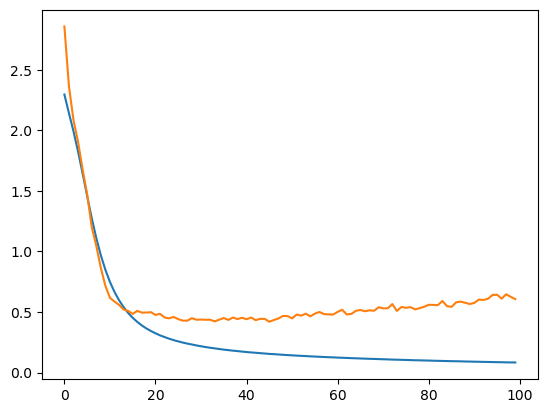

In [75]:
plt.plot(train_losses)
plt.plot(val_losses)

### パラメータのイテレーション

In [76]:
model

MLP(
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)

In [77]:
for param in model.parameters():
    print(param.shape)

torch.Size([30, 64])
torch.Size([30])
torch.Size([10, 30])
torch.Size([10])


In [78]:
for name, param in model.named_parameters():
    print(name, param.shape)

l1.weight torch.Size([30, 64])
l1.bias torch.Size([30])
l2.weight torch.Size([10, 30])
l2.bias torch.Size([10])


### コンポーネントのイテレーション

In [80]:
for module in model.children():
    print(module)

Linear(in_features=64, out_features=30, bias=True)
Linear(in_features=30, out_features=10, bias=True)


In [82]:
for name, module in model.named_children():
    print(name, module)

l1 Linear(in_features=64, out_features=30, bias=True)
l2 Linear(in_features=30, out_features=10, bias=True)


In [81]:
for module in model.modules():
    print(module)

MLP(
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)
Linear(in_features=64, out_features=30, bias=True)
Linear(in_features=30, out_features=10, bias=True)


In [79]:
for name, module in model.named_modules():
    print(name, module)

 MLP(
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)
l1 Linear(in_features=64, out_features=30, bias=True)
l2 Linear(in_features=30, out_features=10, bias=True)
